In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
from collections import Counter
import numpy as np
import scipy as sp
%matplotlib inline


import importlib
import utilities
importlib.reload(utilities)
from utilities import Util

In [10]:
data = pd.read_csv("data_eda.csv", usecols = ["Molecule ChEMBL ID", "Smiles", "Standard Value",
                                                                "Standard Units", "Target ChEMBL ID", 
                                                                "Standard Relation", "Target Name"])

In [11]:
data.head()

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,Target ChEMBL ID,Target Name
0,CHEMBL1374198,CCC(C(=O)Nc1ccccc1)N1CCN(S(=O)(=O)c2ccc3c(c2)C...,'>',55690.00,nM,CHEMBL4026,Signal transducer and activator of transcripti...
1,CHEMBL4465103,C=CC(=O)Nc1cc(Nc2nccc(Nc3ccccc3P(C)(C)=O)n2)c(...,'=',149.00,nM,CHEMBL203,Epidermal growth factor receptor erbB1
2,CHEMBL3931669,CNc1nc2ccccc2n1-c1nc2c(c(C(C)(C)S(C)(=O)=O)n1)...,'=',588.00,nM,CHEMBL2842,Serine/threonine-protein kinase mTOR
3,CHEMBL3355875,COc1cc2ncnc(Nc3ccc(F)c(Cl)c3)c2cc1OCCCCn1ccnc1...,'=',0.47,nM,CHEMBL203,Epidermal growth factor receptor erbB1
4,CHEMBL4224812,C=CC(=O)Nc1cccc(NC(=O)N(C)c2ccnc(Nc3ccc(N4CCN(...,'>',1000.00,nM,CHEMBL203,Epidermal growth factor receptor erbB1


In [12]:
data.shape

(26841, 7)

### Drop NA rows

In [13]:
data.dropna(inplace=True)

In [14]:
# Na values
print("Columns which have empty values: \n\n{} ".format(data.isna().sum()))

Columns which have empty values: 

Molecule ChEMBL ID    0
Smiles                0
Standard Relation     0
Standard Value        0
Standard Units        0
Target ChEMBL ID      0
Target Name           0
dtype: int64 


In [15]:
data.shape

(26833, 7)

## Sort and remove duplicates

In [33]:
# Sort the targets_data to get active results

sorted_data = data.sort_values('Standard Value')

In [35]:
sorted_data = sorted_data.drop_duplicates(subset=['Molecule ChEMBL ID','Target ChEMBL ID'])
sorted_data.head()

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,Target ChEMBL ID,Target Name
7205,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,'=',0.0013,nM,CHEMBL614725,MIA PaCa-2
14802,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,'=',0.0021,nM,CHEMBL614725,MIA PaCa-2
1235,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,'=',0.0030,nM,CHEMBL203,Epidermal growth factor receptor erbB1
3503,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,'=',0.0060,nM,CHEMBL203,Epidermal growth factor receptor erbB1
10367,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,'=',0.0060,nM,CHEMBL203,Epidermal growth factor receptor erbB1


In [37]:
# Check if duplicates are removed
sorted_data[(sorted_data["Target ChEMBL ID"] == "CHEMBL203") & 
                    (sorted_data["Molecule ChEMBL ID"] == "CHEMBL24828")]

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,Target ChEMBL ID,Target Name
12210,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',11.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1


## Add active/inactive

In [38]:
targets_ids = set(data["Target ChEMBL ID"].tolist())
targets_ids

{'CHEMBL1910',
 'CHEMBL1955',
 'CHEMBL1957',
 'CHEMBL203',
 'CHEMBL209',
 'CHEMBL2189121',
 'CHEMBL2842',
 'CHEMBL3474',
 'CHEMBL3580494',
 'CHEMBL4026',
 'CHEMBL614725'}

In [39]:
util_fn = Util(sorted_data, targets_ids)
util_fn.set_target_dict()

{'CHEMBL4026': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL3474': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL1957': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL614725': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL3580494': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL2189121': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL2842': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL1955': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL1910': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL203': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0},
 'CHEMBL209': {'percentiles': [], 25: 0, 50: 0, 75: 0, 100: 0}}

In [40]:
targets_dict = util_fn.set_percentile_count()
targets_dict['CHEMBL203']

{'percentiles': [0.003, 27.0, 333.0, 6500.0, 25000000.0],
 25: 2129,
 50: 2102,
 75: 2116,
 100: 2114}

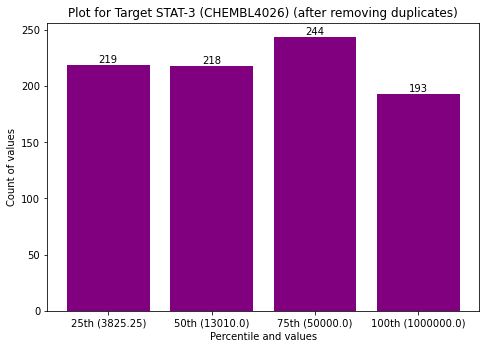

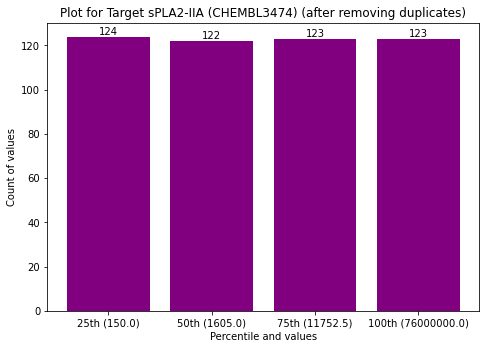

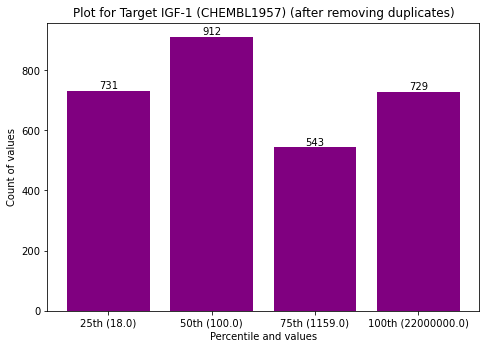

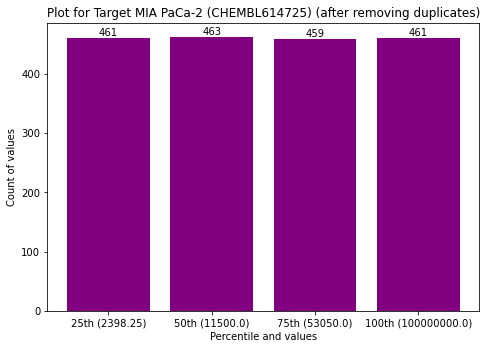

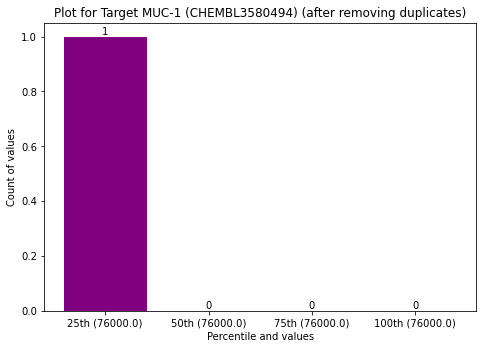

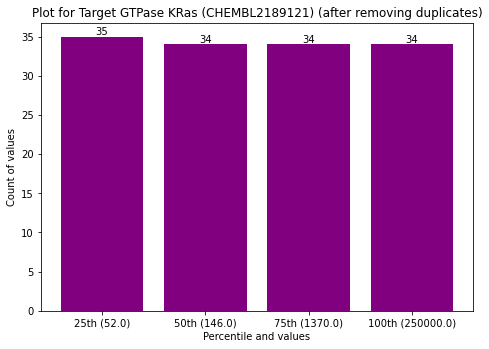

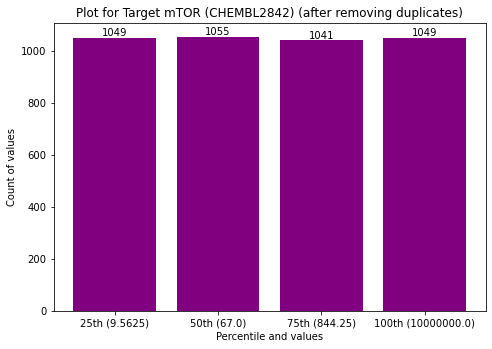

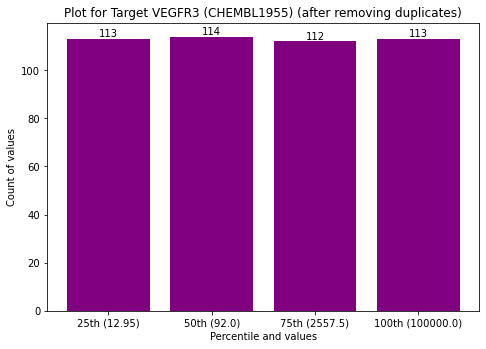

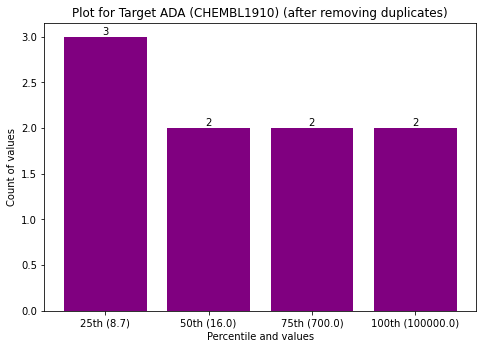

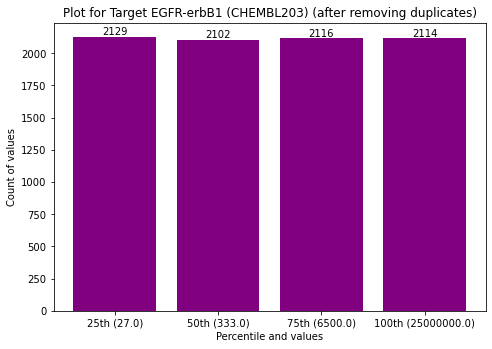

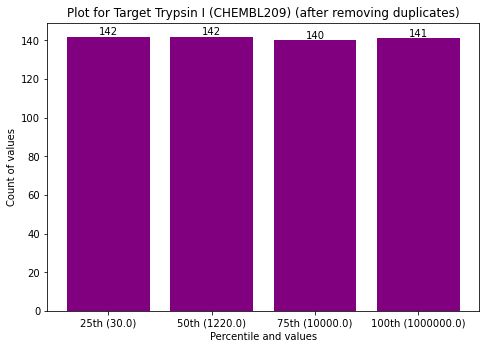

In [41]:
# Data after removing duplicates
for target in targets_dict:
    fig = plt.figure(figsize=(6, 4))
    ax = fig.add_axes([0,0,1,1])
    percentiles = targets_dict[target]["percentiles"]
    x_axis = ['25th ({})'.format(percentiles[1]), '50th ({})'.format(percentiles[2]), 
              '75th ({})'.format(percentiles[3]), '100th ({})'.format(percentiles[4])]
    y_axis = [targets_dict[target][25],targets_dict[target][50],
                targets_dict[target][75],targets_dict[target][100]]

    
    ax.bar(x_axis,y_axis, color='purple')
    for i in range(len(y_axis)):
        plt.annotate(str(y_axis[i]), xy=(x_axis[i],y_axis[i]), ha='center', va='bottom')

    
    plt.xlabel("Percentile and values")
    plt.ylabel("Count of values")
    plt.title("Plot for Target {} ({}) (after removing duplicates)".format(util_fn.target_abbr_from_id(target), 
                                                                           target))
    plt.show()

In [60]:
targets_500_assays = []
updated_tids = []
for target in targets_dict:
    count_25 = targets_dict[target][25]
    count_100 = targets_dict[target][100]
    total_count = count_25 + count_100
    if (count_25 + count_100) >= 500:
        targets_500_assays.append((target, util_fn.target_abbr_from_id(target)))
        updated_tids.append(target)
targets_500_assays

[('CHEMBL1957', 'IGF-1'),
 ('CHEMBL614725', 'MIA PaCa-2'),
 ('CHEMBL2842', 'mTOR'),
 ('CHEMBL203', 'EGFR-erbB1')]

### Filter data based on these targets

In [62]:
data_targets = sorted_data.loc[(sorted_data['Target ChEMBL ID'].isin(updated_tids)) ]
data_targets.shape

(17414, 7)

In [70]:
data_targets[(data_targets['Target ChEMBL ID'] == 'CHEMBL1957') & data_targets['Standard Value'] <= 18.0 ]

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,Target ChEMBL ID,Target Name
7205,CHEMBL2321905,COC(=O)c1cc(-c2ccc(NC(=O)c3cc(NC(=O)CCCOc4cc5c...,'=',1.300000e-03,nM,CHEMBL614725,MIA PaCa-2
14802,CHEMBL2324630,COC(=O)c1cc(-c2ccc(NC(=O)c3nc(NC(=O)CCCOc4cc5c...,'=',2.100000e-03,nM,CHEMBL614725,MIA PaCa-2
1235,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,'=',3.000000e-03,nM,CHEMBL203,Epidermal growth factor receptor erbB1
3503,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,'=',6.000000e-03,nM,CHEMBL203,Epidermal growth factor receptor erbB1
10367,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,'=',6.000000e-03,nM,CHEMBL203,Epidermal growth factor receptor erbB1
...,...,...,...,...,...,...,...
24910,CHEMBL1956069,COc1cccc(C(=O)c2sc(Nc3ccc(N4CCN(C(C)C)CC4)cc3)...,'=',2.000000e+07,nM,CHEMBL1957,Insulin-like growth factor I receptor
20086,CHEMBL1956070,CN1CCN(c2ccc(Nc3nc(N)c(C(=O)c4ccc5c(c4)OCCO5)s...,'=',2.200000e+07,nM,CHEMBL1957,Insulin-like growth factor I receptor
21689,CHEMBL1431,CN(C)C(=N)NC(=N)N,'=',2.226319e+07,nM,CHEMBL614725,MIA PaCa-2
16923,CHEMBL45068,O=C(CCc1ccc(O)cc1)c1c(O)cc(O)cc1O,'=',2.500000e+07,nM,CHEMBL203,Epidermal growth factor receptor erbB1


### Filter based on Standard Value and add active/Inactive

In [87]:
def add_active(row, ll, ul):
    sv = row["Standard Value"]
    sr = row["Standard Relation"]
    if int(sv) <= ll and sr != '>':
        return 1
    else:
        return 0

In [147]:
def plot_active_inactive_stats(x, y, target):

    x_pos = [i for i, _ in enumerate(x)]

    plt.bar(x_pos, y, color='purple')
    for i in range(len(y)):
        plt.annotate(str(y[i]), xy=(x[i],y[i]), ha='center', va='bottom')
    plt.xlabel("Active (1) and Inactive (0)")
    plt.ylabel("Count of values")
    plt.title("Plot for Active/Inactive {} ({})".format(util_fn.target_abbr_from_id(target), 
                                                                           target))

    plt.xticks(x_pos, x)

    plt.show()



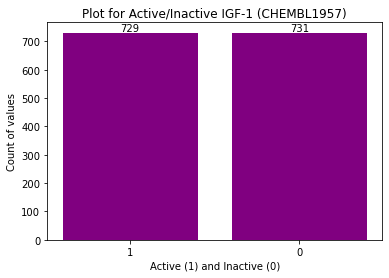

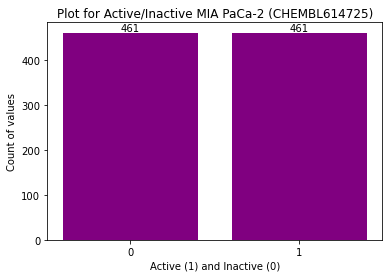

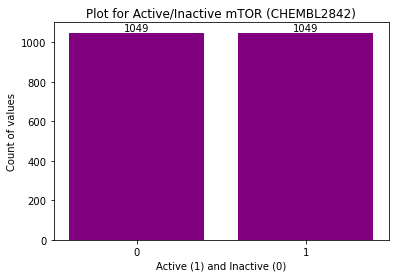

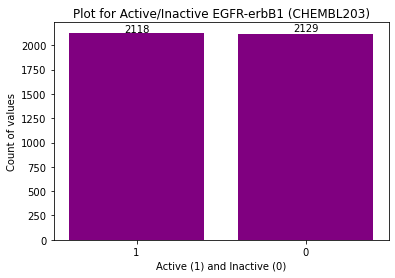

In [149]:
target_dfs = []
target_act_inact_count = {}


for target in updated_tids:
    per_25 = float(targets_dict[target]["percentiles"][1])
    per_75 = float(targets_dict[target]["percentiles"][3])
    df = data_targets[(data_targets['Target ChEMBL ID'] == target)]
    df = df[(df['Standard Value'] <= per_25) | (df['Standard Value'] >= per_75)]
    df['Active'] = df.apply(add_active, args=(per_25,per_75), axis=1)
    #target_act_inact_count[target]['active_count'] = len(df[df['Active'] == 1])
    
    x_vals = df['Active'].value_counts().index.tolist()
    y_vals = df['Active'].value_counts().values.tolist()

    plot_active_inactive_stats(x_vals, y_vals, target)
    
    target_dfs.append(df)
    
    
cleaned_data = pd.concat(target_dfs)

In [150]:
cleaned_data.to_csv("Cleaned.csv")

## Extra Things to consider

In [70]:
interaction_count = group_data.value_counts().sort_index().index.tolist()
interaction_vals = group_data.value_counts().sort_index().values.tolist()

print(interaction_vals)
print(interaction_count)

[15308, 2849, 496, 179, 49, 23, 18, 5, 3, 4, 3, 2, 3, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 19, 24, 28, 29, 36, 37, 60, 82, 123]


In [33]:
target_mol_inter = group_data.to_frame()
counter_values = target_mol_inter[target_mol_inter['COUNTER_INT'] == 1]
list_interactions = list(set(counter_values.index)) 
a_list = [a_tuple[1:] for a_tuple in list_interactions]

targets = []

for t in set(a_list):
    targets.append(t[0])

print('Targets with  1 interactions are \n\n{} '.format(targets))

Targets with  1 interactions are 

['CHEMBL4026', 'CHEMBL209', 'CHEMBL2189121', 'CHEMBL614725', 'CHEMBL1957', 'CHEMBL3474', 'CHEMBL1955', 'CHEMBL3331', 'CHEMBL203', 'CHEMBL2842'] 


In [71]:
target_mol_data =  target_data[target_data['Target ChEMBL ID'].isin(targets)]
target_mol_data.shape

(24427, 8)

In [208]:
target_mol_data.to_csv("Cleaned-data.csv")

In [39]:
target_mol_data[(target_mol_data["Target ChEMBL ID"] == "CHEMBL203") & (target_mol_data["Molecule ChEMBL ID"] == "CHEMBL24828")]

,Molecule ChEMBL ID,Smiles,Standard Relation,Standard Value,Standard Units,Target ChEMBL ID,Target Name,COUNTER_INT
10,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'>',10000.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
1238,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',112.4,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
3318,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',16.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
3908,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',190.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
6087,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',500.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
6688,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',500.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
8529,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',100.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
13493,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',800.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
14171,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',800.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
15379,CHEMBL24828,COc1cc2c(Nc3ccc(Br)cc3F)ncnc2cc1OCC1CCN(C)CC1,'=',200.0,nM,CHEMBL203,Epidermal growth factor receptor erbB1,1
